# Predicting Credit Card Fraud

In my current position at SmartBiz, I am the data sherpa, and that means I'm at the intersection of all business units and their data needs. I've been fortunate to have opportunities to work with our Data Science team and ultimately found that this area is one where I really want to move forward in.

One of the major projects I collaborated with the Data Science team on was predictive modeling of the performance of loans. This was a 

## Goal
- Produce a predictive model as evaluated by Area Under the Precision-Recall Curve and Average Precision Score.

## Process
- Explore Data
- Slice a few different ways and compare model performance between the methods:
    - Raw features
    - Features with high variance between classes (`high_var_feats`)
    - Using `high_var_features`, perform DFS to generate more features (`dfs_feats`)
    - Using `dfs_features`, perform CV RFE to determine optimal number of features and which features to keep (`rfe_feats`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('./data/creditcard.csv')

## Exploring data
Let's go through the basics and explore this dataset.

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
compare_means = pd.concat([
    data[data['Class'] == 0].mean().round(3),
    data[data['Class'] == 1].mean().round(3)
], axis = 1)

compare_means.columns = ['Legit','Fraud']

compare_means['AbsVar'] = abs(compare_means['Fraud'] - compare_means['Legit'])

compare_means['AbsPct'] = (compare_means['AbsVar'] / compare_means['Legit']).round(3) * 100


In [6]:
compare_means.sort_values(by='AbsVar', ascending=False)

,Legit,Fraud,AbsVar,AbsPct
Time,94838.202,80746.807,14091.395,14.9
Amount,88.291,122.211,33.920,38.4
V3,0.012,-7.033,7.045,58708.3
V14,0.012,-6.972,6.984,58200.0
V17,0.012,-6.666,6.678,55650.0
V12,0.011,-6.259,6.270,57000.0
V10,0.010,-5.677,5.687,56870.0
V7,0.010,-5.569,5.579,55790.0
V1,0.008,-4.772,4.780,59750.0
V4,-0.008,4.542,4.550,-56875.0


In [7]:
compare_std = pd.concat([
    data[data['Class'] == 0].std().round(3),
    data[data['Class'] == 1].std().round(3)
], axis = 1)

compare_std.columns = ['Legit','Fraud']

compare_std['Var'] = compare_std['Fraud'] - compare_std['Legit']

compare_std['AbsPct'] = (compare_std['Var'] / compare_std['Legit']).round(3) * 100

compare_std.columns = ['{}_std'.format(i) for i in compare_std.columns]


In [8]:
compare_std.sort_values(by='AbsPct_std', ascending=False)

,Legit_std,Fraud_std,Var_std,AbsPct_std
V17,0.749,6.971,6.222,830.7
V7,1.179,7.207,6.028,511.3
V8,1.161,6.798,5.637,485.5
V21,0.717,3.869,3.152,439.6
V12,0.946,4.654,3.708,392.0
V3,1.459,7.111,5.652,387.4
V14,0.897,4.279,3.382,377.0
V10,1.044,4.897,3.853,369.1
V16,0.845,3.865,3.020,357.4
V5,1.357,5.372,4.015,295.9


In [9]:
compare_mean_and_std = pd.concat([
    compare_means,
    compare_std
], axis = 1)

In [10]:
compare_mean_and_std['quotient'] = compare_mean_and_std['AbsVar'] / compare_mean_and_std['Var_std']

In [11]:
compare_mean_and_std[
    compare_mean_and_std['quotient'] > 0.75
].sort_values(by='quotient', ascending=False)

,Legit,Fraud,AbsVar,AbsPct,Legit_std,Fraud_std,Var_std,AbsPct_std,quotient
Class,0.000,1.000,1.000,inf,0.000,0.000,0.000,NaN,inf
Time,94838.202,80746.807,14091.395,14.9,47484.016,47835.365,351.349,0.7,40.106546
Amount,88.291,122.211,33.920,38.4,250.105,256.683,6.578,2.6,5.156583
V4,-0.008,4.542,4.550,-56875.0,1.399,2.873,1.474,105.4,3.086839
V6,0.002,-1.398,1.400,70000.0,1.330,1.858,0.528,39.7,2.651515
V11,-0.007,3.800,3.807,-54385.7,1.003,2.679,1.676,167.1,2.271480
V14,0.012,-6.972,6.984,58200.0,0.897,4.279,3.382,377.0,2.065050
V9,0.004,-2.581,2.585,64625.0,1.089,2.501,1.412,129.7,1.830737
V12,0.011,-6.259,6.270,57000.0,0.946,4.654,3.708,392.0,1.690939
V10,0.010,-5.677,5.687,56870.0,1.044,4.897,3.853,369.1,1.475993


In [12]:
high_var_feats = compare_mean_and_std[
    compare_mean_and_std['quotient'] > 0.75
].sort_values(by='quotient', ascending=False).index

In [13]:
high_var_feats

Index(['Class', 'Time', 'Amount', 'V4', 'V6', 'V11', 'V14', 'V9', 'V12', 'V10',
       'V16', 'V2', 'V3', 'V18', 'V17', 'V13', 'V1', 'V19', 'V7', 'V5'],
      dtype='object')

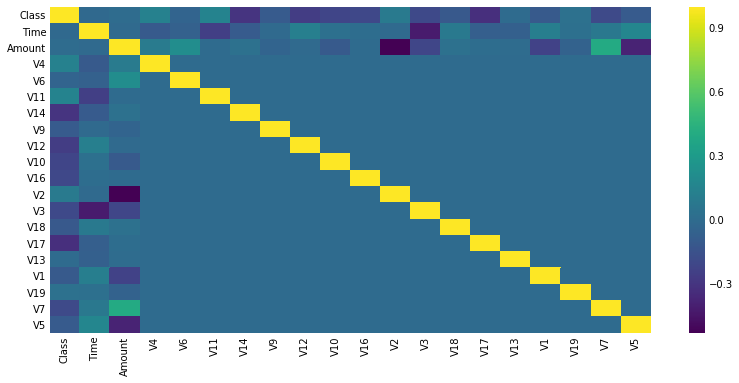

In [14]:
plt.figure(figsize=(12,6))
sns.heatmap(data[high_var_feats].corr(),cmap='viridis')

In [15]:
# Compare distributions of the Classes
from MyDataTools import explore

In [16]:
e = explore()

In [17]:
# High Var Feats
data_high_var = data[high_var_feats]

## Data Check
- Null values?
- Normalizing?
- Incorrect values?
- Possibility of feature engineering?

In [18]:
data.Class.sum()

492

In [19]:
len(data.Class)

284807

In [20]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [21]:
# from sklearn.preprocessing import StandardScaler

# S = StandardScaler()

# data['Time_scaled'] = S.fit_transform(X=data[['Time']])
# data['Amount_scaled'] = S.fit_transform(X=data[['Amount']])

In [22]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Seems like everything's there. That makes things easy. Let's get weird.

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

## Bonus packages
# from imblearn.over_sampling import SMOTE, BorderlineSMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

In [28]:
# Raw values first
X = data.drop(columns=['Class'])
y = data.Class

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [30]:
from MyDataTools import model

m = model()

# bsmote = BorderlineSMOTE()

# rus = RandomUnderSampler()

rf0 = RandomForestClassifier(n_estimators=50)

xgb = XGBClassifier()

# pipe_rf_os = Pipeline(steps=[
#     ('BSMOTE',bsmote),
#     ('rf0',rf0)
# ])

# pipe_rf_us = Pipeline(steps=[
#     ('RUS',rus),
#     ('rf0',rf0)
# ])

gb0 = GradientBoostingClassifier(n_estimators=50)

In [31]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [32]:
preds = xgb.predict(X_test)

In [33]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [34]:
print(confusion_matrix(y_test, preds))

[[56859     5]
 [   26    72]]


In [35]:
probas = xgb.predict_proba(X_test)[:,1]

In [36]:
from sklearn.metrics import average_precision_score, recall_score, precision_score

In [37]:
average_precision_score(y_test, probas)


0.8036637536999544

In [38]:
recall_score(y_test, preds)

0.7346938775510204

In [39]:
thres = m.optimal_cutoff(y_test, probas)[0]

In [40]:
print(thres)

0.0006662164232693613


In [41]:
preds_thres = [x > thres for x in probas]

In [42]:
print(classification_report(y_test, preds_thres))
print('\n')
print(confusion_matrix(y_test, preds_thres))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.02      0.93      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.96     56962



[[53187  3677]
 [    7    91]]


In [43]:
precision_score(y_test, preds)

0.935064935064935

In [45]:
from xgboost import cv, DMatrix
from sklearn.metrics import average_precision_score, make_scorer
from skopt import BayesSearchCV

avg_prec = make_scorer(average_precision_score, needs_proba=True)

In [106]:
Integer(3,10)

Integer(low=3, high=10)

In [120]:
from skopt.space import Real, Categorical, Integer
from xgboost import DMatrix, cv
from sklearn.metrics import accuracy_score, roc_auc_score

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [134]:
xgbcvresult

,train-map-mean,train-map-std,test-map-mean,test-map-std
0,0.742116,0.033495,0.675473,0.048429
1,0.778420,0.021718,0.725302,0.026835
2,0.801967,0.005910,0.740204,0.035584
3,0.810135,0.010854,0.748406,0.038068
4,0.811081,0.013416,0.761520,0.023413
5,0.816423,0.009972,0.773664,0.027283
6,0.819866,0.009887,0.778024,0.029492
7,0.823618,0.007431,0.786081,0.024823
8,0.826515,0.006782,0.777926,0.025944
9,0.831768,0.004785,0.788102,0.029363


In [143]:
from sklearn.metrics import average_precision_score

def modelfit(alg, useTrainCV=False, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = DMatrix(X_train.values, label=y_train.values)
        cvresult = cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='map', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric=avg_prec)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Mean Average Precision : %.4g" % average_precision_score(y_train, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Mean Average Precision : 0.9226


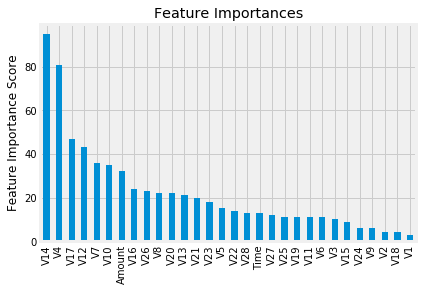

In [144]:
modelfit(xgb)

In [147]:
xgb.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)>

In [148]:
xgb_space = {
    'max_depth':Integer(3,20),
    'min_child_weight':Integer(1,10),
    'subsample':[i/10.0 for i in range(6,10)],
     'gamma':[i/10.0 for i in range(0,9)],
     'colsample_bytree':[i/10.0 for i in range(3,10)]
}

In [164]:
xgb_bo1 = BayesSearchCV(estimator=xgb, 
                        search_spaces=xgb_space,
                        scoring=avg_prec,
                        n_iter=10,
                        cv=5,
                       verbose=1,
                       n_jobs=4)


xgb_bo1.fit(X_val, y_val)
xgb_bo1.best_score_, xgb_bo1.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s finished


(0.8077762728409391,
 {'colsample_bytree': 0.5,
  'gamma': 0.7,
  'max_depth': 6,
  'min_child_weight': 2,
  'subsample': 0.8})

In [165]:
xgb_bo1.best_estimator_.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0.7,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [166]:
preds_bo1 = xgb_bo1.best_estimator_.predict(X_test)

In [167]:
print(classification_report(y_test, preds_bo1))
print('\n')
print(confusion_matrix(y_test, preds_bo1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.80      0.87        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.98      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



[[56860     4]
 [   20    78]]


In [168]:
thres_bo1 = m.optimal_cutoff(y_test, xgb_bo1.best_estimator_.predict_proba(X_test)[:,1])[0]

In [169]:
print(thres_bo1)

0.0005695774452760816


In [170]:
preds_new = [x > thres_bo1 for x in xgb_bo1.best_estimator_.predict_proba(X_test)[:,1]]

In [171]:
print(classification_report(y_test, preds_new))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.94      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962



In [172]:
print(confusion_matrix(y_test, preds_new))

[[53424  3440]
 [    6    92]]


In [179]:
X_test.loc[y_test.loc[y_test == 1].index]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
64329,51112.0,-9.848776,7.365546,-12.898538,4.273323,-7.611991,-3.427045,-8.350808,6.863604,-2.387567,...,0.832398,0.931958,-0.874467,-0.192639,-0.035426,0.538665,-0.263934,1.134095,0.225973,99.99
6820,8614.0,-2.169929,3.639654,-4.508498,2.730668,-2.122693,-2.341017,-4.235253,1.703538,-1.305279,...,0.500779,0.645103,-0.503529,-0.000523,0.071696,0.092007,0.308498,0.552591,0.298954,1.00
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
201098,133731.0,1.176633,3.141918,-6.140445,5.521821,1.768515,-1.727186,-0.932429,0.292797,-3.156827,...,0.329568,0.129372,-0.803021,-0.074098,-0.031084,0.375366,0.065897,0.488258,0.325872,0.00
30398,35906.0,-3.519030,4.140867,-3.628202,5.505672,-4.057463,-0.905945,-6.652031,2.634524,-4.679402,...,0.898723,1.582556,0.778710,-0.135707,-0.004278,0.032706,0.362014,0.900925,0.554897,9.13
167305,118603.0,-6.677212,5.529299,-7.193275,6.081321,-1.636071,0.500610,-4.640770,-4.339840,-0.950036,...,-1.118687,5.563301,-1.608272,0.965322,0.163718,0.047531,0.466165,0.278547,1.471988,105.89
52521,45501.0,1.001992,0.047938,-0.349002,1.493958,0.186939,0.190966,-0.001112,0.147140,0.580415,...,0.016004,-0.334417,-1.014315,-0.128427,-0.946242,0.456090,-0.453206,0.046627,0.064698,105.99
255403,157207.0,1.170756,2.501038,-4.986159,5.374160,0.997798,-1.259004,-1.237689,0.358426,-2.612489,...,0.227618,0.123145,-0.713201,-0.080868,-0.964310,0.338568,0.068630,0.481588,0.268226,4.97
149587,91524.0,1.954852,1.630056,-4.337200,2.378367,2.113348,-1.583851,0.653745,-0.192892,1.217608,...,-0.230640,-0.474437,-0.974625,-0.048155,-0.023524,0.362192,-0.570709,0.025619,0.081880,1.00
154587,102114.0,-28.255053,21.467203,-26.871339,11.737436,-17.999630,6.065901,-41.506796,-38.987263,-13.434066,...,10.440718,-21.453736,8.361985,4.909111,0.098328,-1.508739,0.008711,-5.407824,-0.183811,0.00


In [77]:
xgb_bo2.best_estimator_.fit(X_train, y_train)

preds_bo2 = xgb_bo2.best_estimator_.predict(X_test)

print(classification_report(y_test, preds_bo2))
print('\n')
print(confusion_matrix(y_test, preds_bo2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



[[56859     5]
 [   26    72]]


In [89]:
thres_bo2 = m.optimal_cutoff(y_test, xgb_bo2.best_estimator_.predict_proba(X_test)[:,1])[0]
print(thres_bo2)
preds_new2 = [x > thres_bo2 for x in xgb_bo2.best_estimator_.predict_proba(X_test)[:,1]]
print(classification_report(y_test, preds_new2))
print('\n')
print(confusion_matrix(y_test, preds_new2))

0.000713554909452796
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.94      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962



[[53379  3485]
 [    6    92]]


In [90]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_bo3 = BayesSearchCV(estimator=xgb_bo2.best_estimator_, 
                        search_spaces= param_test3,
                      scoring=avg_prec,
                      n_iter=5)


xgb_bo3.fit(X_val, y_val)

C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 

BayesSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_iter=5, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False,
       scoring=make_scorer(average_precision_score, needs_proba=True),
       search_spaces={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}, verbose=0)

In [91]:
xgb_bo3.best_estimator_.fit(X_train, y_train)

preds_bo3 = xgb_bo3.best_estimator_.predict(X_test)

print(classification_report(y_test, preds_bo3))
print('\n')
print(confusion_matrix(y_test, preds_bo3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



[[56859     5]
 [   26    72]]


In [92]:
thres_bo3 = m.optimal_cutoff(y_test, xgb_bo3.best_estimator_.predict_proba(X_test)[:,1])[0]
print(thres_bo2)
preds_new3 = [x > thres_bo2 for x in xgb_bo3.best_estimator_.predict_proba(X_test)[:,1]]
print(classification_report(y_test, preds_new3))
print('\n')
print(confusion_matrix(y_test, preds_new3))

0.000713554909452796
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962



[[53357  3507]
 [    7    91]]
